# Main

In [15]:
from snowflake.snowpark.session import Session
import json
from utils import *

In [16]:
with open("config.json", "r") as file:
    connection_parameters = json.load(file)

In [2]:
# Snowflake config.
sfACCOUNT='bx74413.west-europe.privatelink'
sfUSER = 'alberto.quinterobejarano@colaborador.elcorteingles.es'
sfROLE = 'CAAR_FORECAST'
sfWAREHOUSE = 'WH_FORECAST'
sfDATABASE = 'CAA_UAT'
sfSCHEMA = 'STG_FORECAST'

connection_parameters = {
    'ACCOUNT': sfACCOUNT,
    'USER': sfUSER,
    'ROLE': sfROLE,
    'WAREHOUSE': sfWAREHOUSE,
    'DATABASE':  sfDATABASE,
    'SCHEMA': sfSCHEMA,
    'AUTHENTICATOR': 'externalbrowser'
}


In [3]:
sess = Session.builder.configs( connection_parameters ).create()

c:\Users\julian.quintero\FCPDIHC\PDIHC\.venv\Lib\site-packages\snowflake\connector\config_manager.py:351: UserWarning: Bad owner or permissions on C:\Users\julian.quintero\.snowflake\connections.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://identity-services.elcorteingles.es:443/samlsso?SAMLRequest=pZJNc9owEIb%2Fikc9W%2F7AoY0Gk6EwTJmmKQ2GpL0Je8EaZMnVyhj%2BfWUcZtJDcslNH%2B%2FuPrvvju5OlfSOYFBolZKIhsQDletCqH1K1tnc%2F0I8tFwVXGoFKTkDkrvxCHklazZpbKke4W8DaD2XSCG7fKSkMYppjgKZ4hUgszlbTX7cs5iGrDba6lxL8irk%2FQiOCMY6wmtIgcLhldbWLAjatqXtgGqzD%2BIwDIPwNnCqTvLpqj%2B5nt7QR0GYdHqncPLlC9tXofoRvIe17UXIvmXZ0l%2F%2BXGXEm1xRp1phU4FZgTmKHNaP9z0AOoLt6XOSRAPaurn50BhdA62NOHILUqgDRaXbneQHyHVVN9bVoO4U7KAIpN4LN4bFLCX1QRTFoqqOz8nxqfi1edpmw3KoYd5G5W69uW3a77Ge8%2Bm%2BLKer%2Fe%2BceJurz3Hn8wKxgYXq3LXuKYwTP4r9eJBFCbuJWTyg8fDmD%2FFmjlIobi%2BR1xZEAcoKe%2Fax7w8pyFwbCw5WdjdkSTIIOm8RNek3hl1KmvHH5jAKXud6WcUH585ittRS5Gdvrk3F7dvmRTS6vIjC312kDCou5KQoDCA6E6XU7dSA40iJNQ2QYNxX%2FX%2Fnx%2F8A&RelayState=ver%3A1-hint%3

In [5]:
alpha = 0.05
T_burnin = 120
lr = 0.01
Csat = 2.5
KI = 1.0
ahead = 1
seasonal_period = 7
n_series=3
n_points=365*2

In [6]:
df_snw = sess.sql( '''
    SELECT LEVEL, KEY, DT_REF,  FUTURE ,FECHA, Y, YHATFIN, YHAT_L, YHAT_U, YHAT1, YHAT2
    FROM CAA.STG_FCDP.TB_DEMAND_PLANNING_FORECAST_DEV  
    WHERE DT_REF ='2024-12-22' AND LEVEL IN ('<P>_TotD', '<P>_Prime', '<P>_LibeCsTMod') --'<P>_PrepCcDC',
''' )

In [7]:
df = df_snw.to_pandas()

In [8]:
df2 = assign_data_sets(df, date_col="FECHA", future_col="FUTURE", calib_ratio=0.4)

In [9]:
#df = generar_datos(n_series=n_series, n_points=n_points, seed=123, start_date="2023-01-01")
#df = assign_data_sets(df, date_col="FECHA", future_col="FUTURE", calib_ratio=0.4)

In [12]:
df_pdi, logs = apply_pdi_with_calibration_with_diagnostics(
    df=df2,
    key_col="KEY",
    date_col="FECHA",
    value_col="Y",
    pred_col="YHATFIN",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha,
    lr=lr,
    T_burnin=T_burnin,
    Csat=Csat,
    KI=KI,
    ahead=ahead,
    seasonal_period=seasonal_period,
    set_col="SET"
)

 74%|███████▍  | 20/27 [01:22<00:28,  4.12s/it]

⚠️ Conjunto de entrenamiento vacío para 00149.


100%|██████████| 27/27 [01:45<00:00,  3.91s/it]


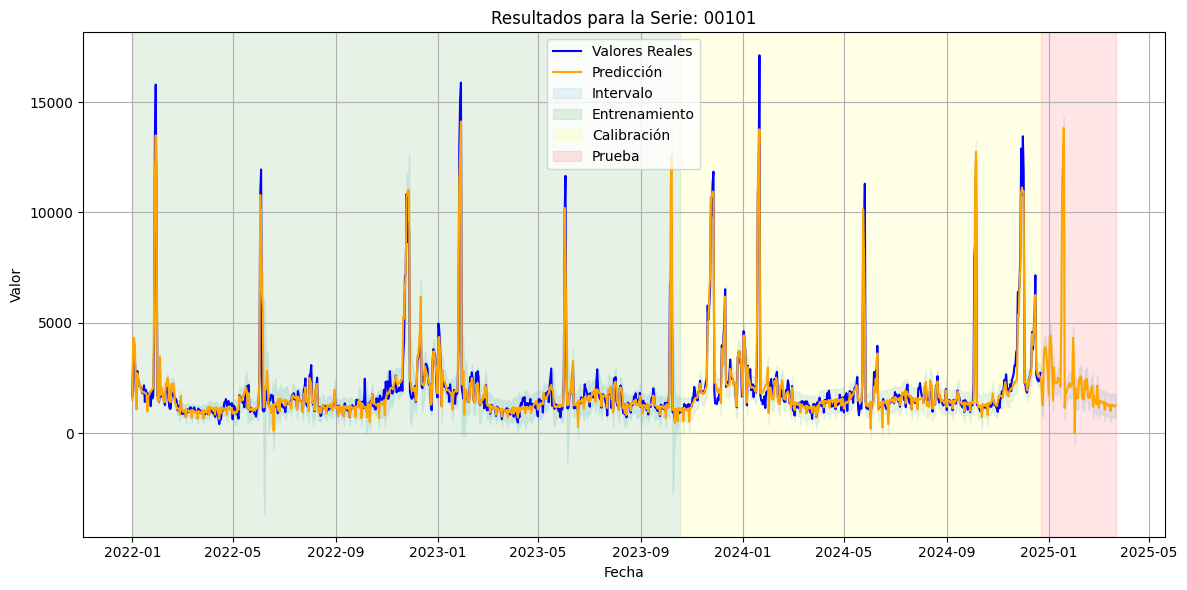

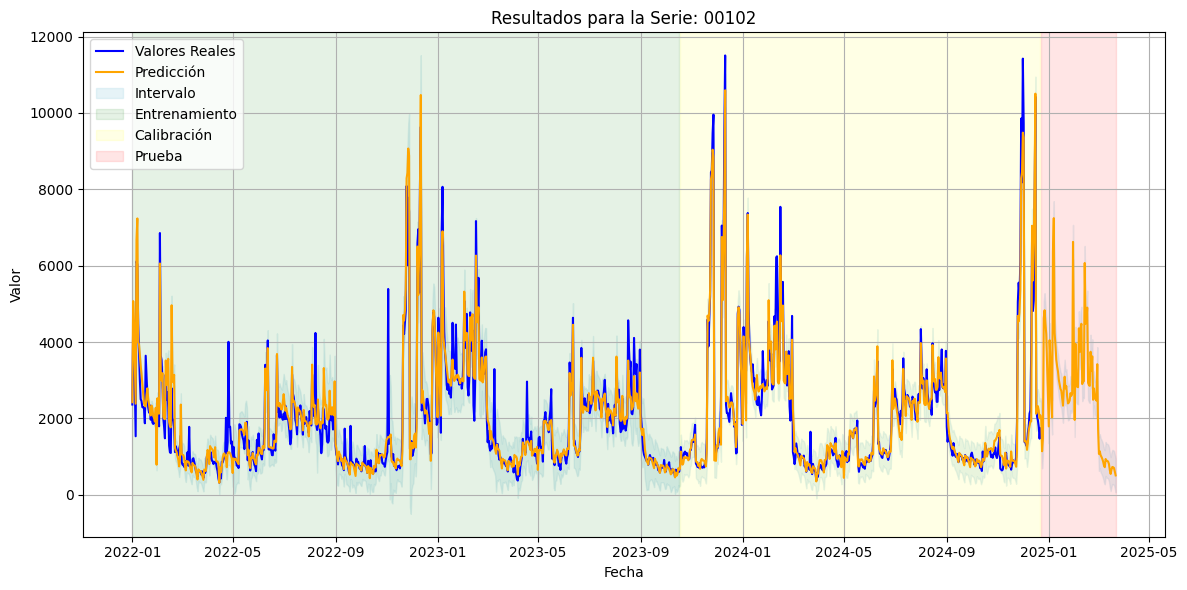

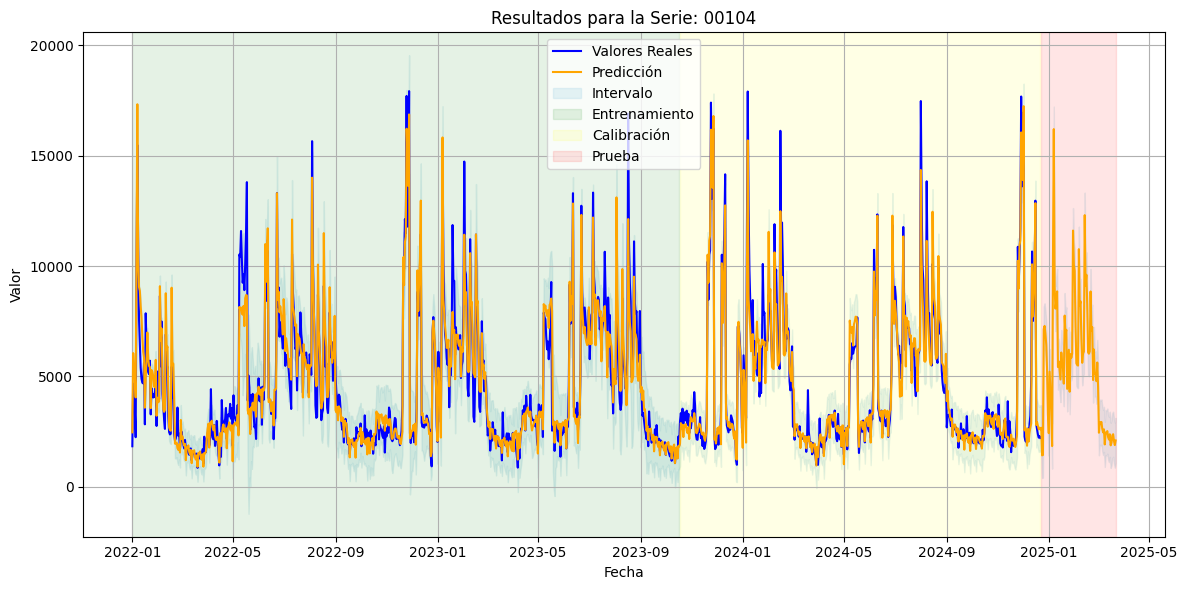

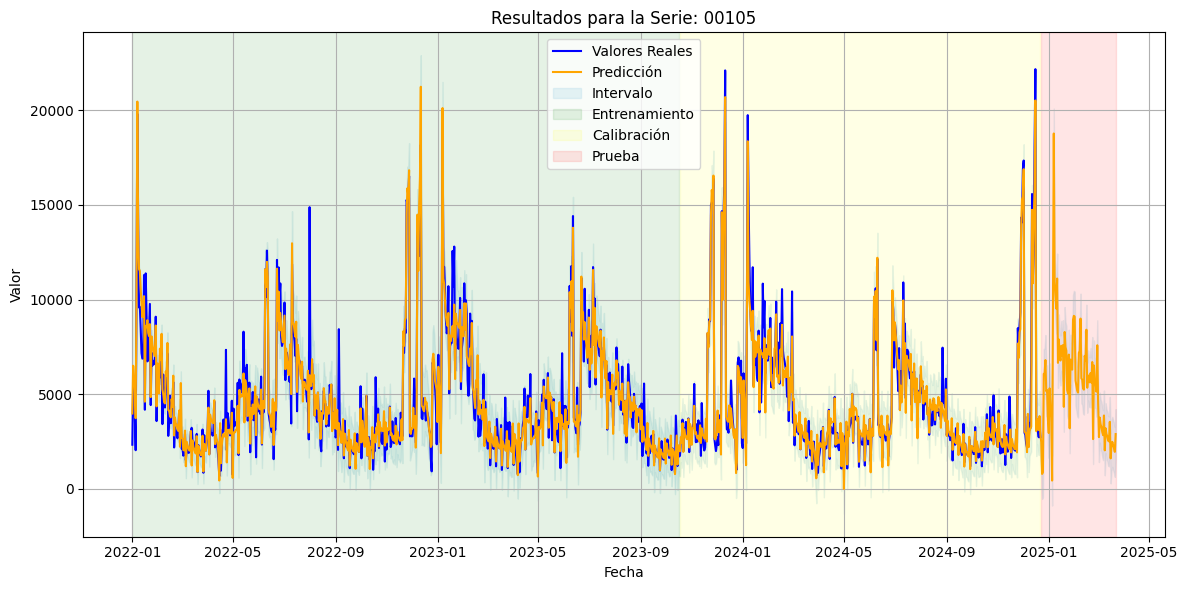

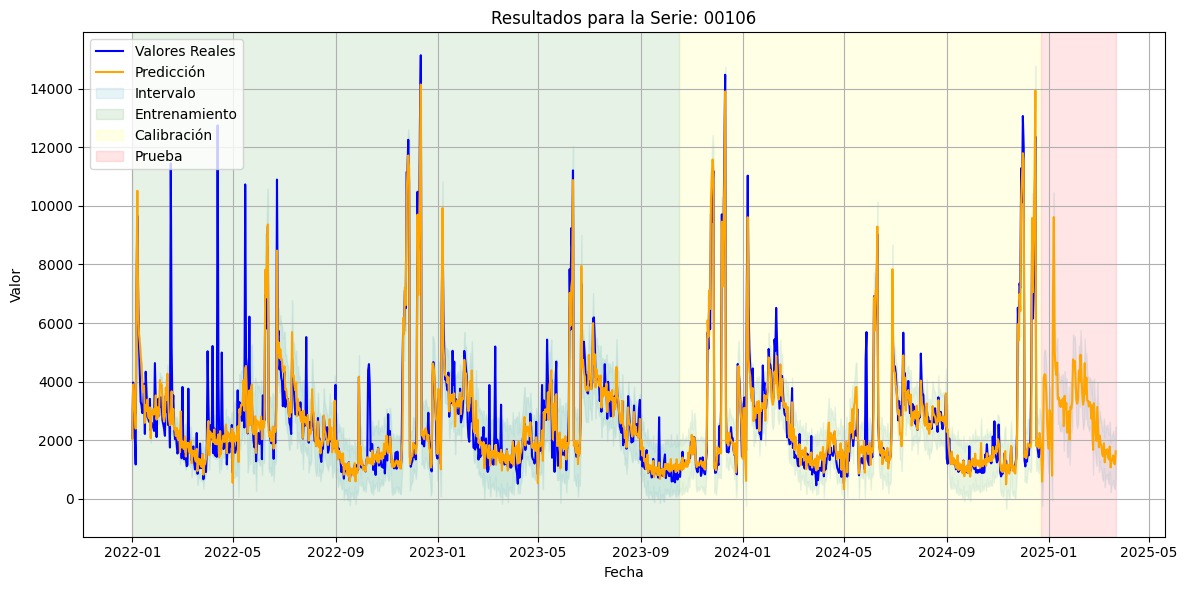

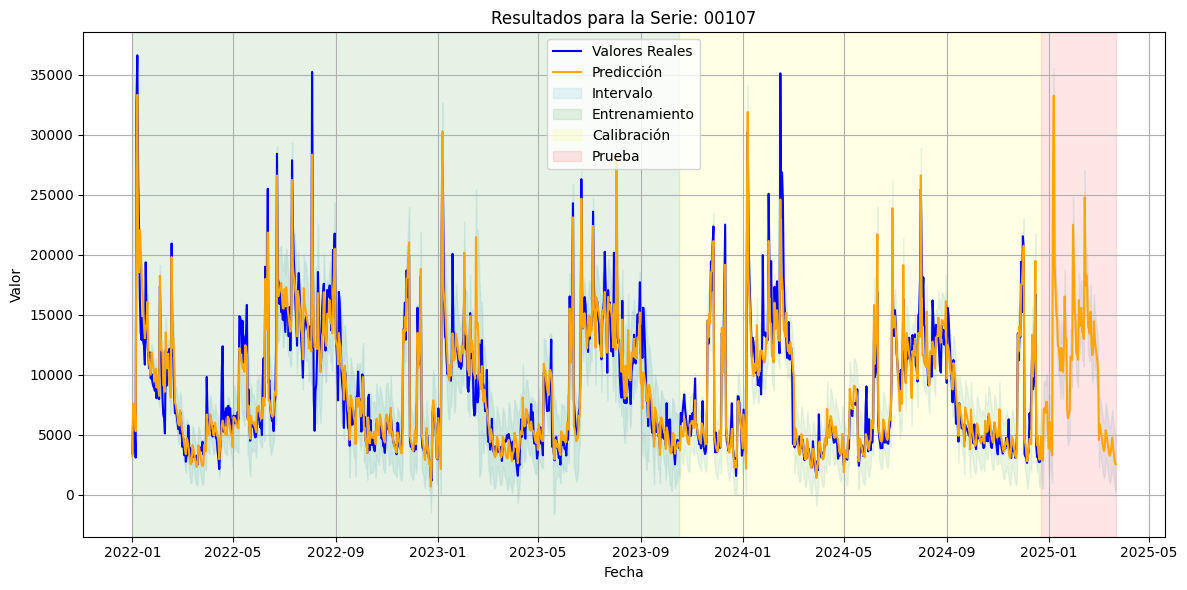

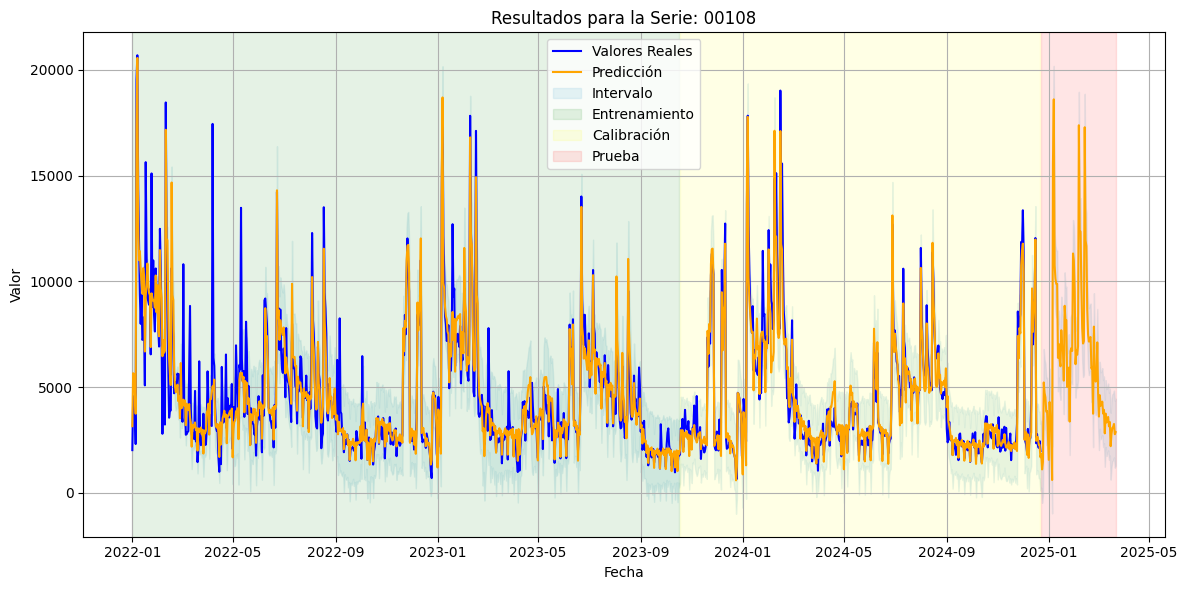

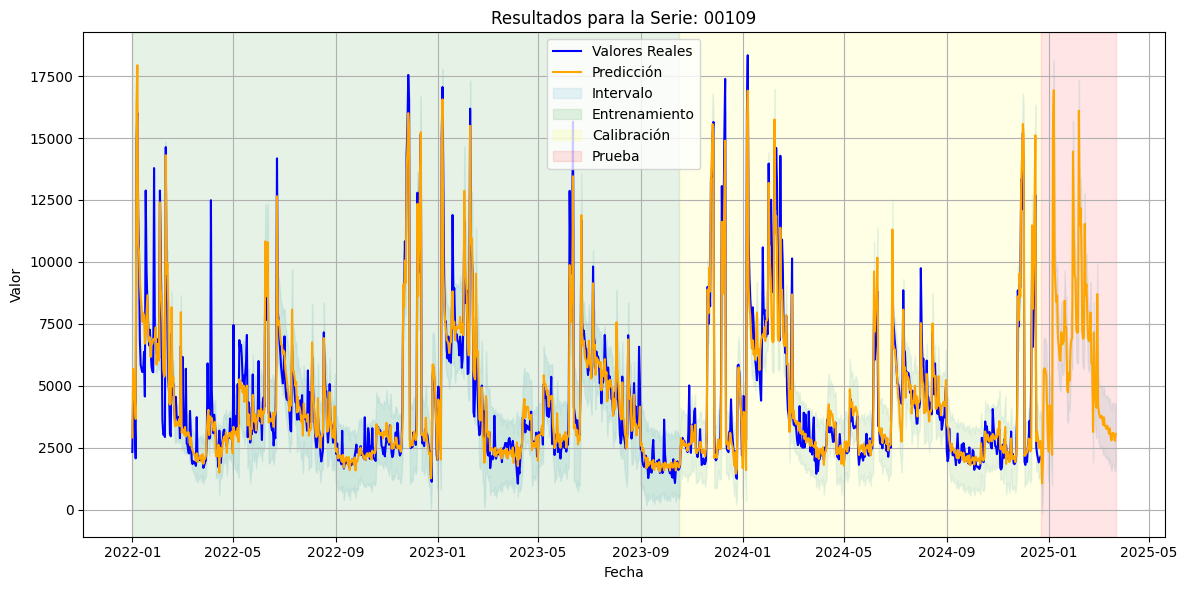

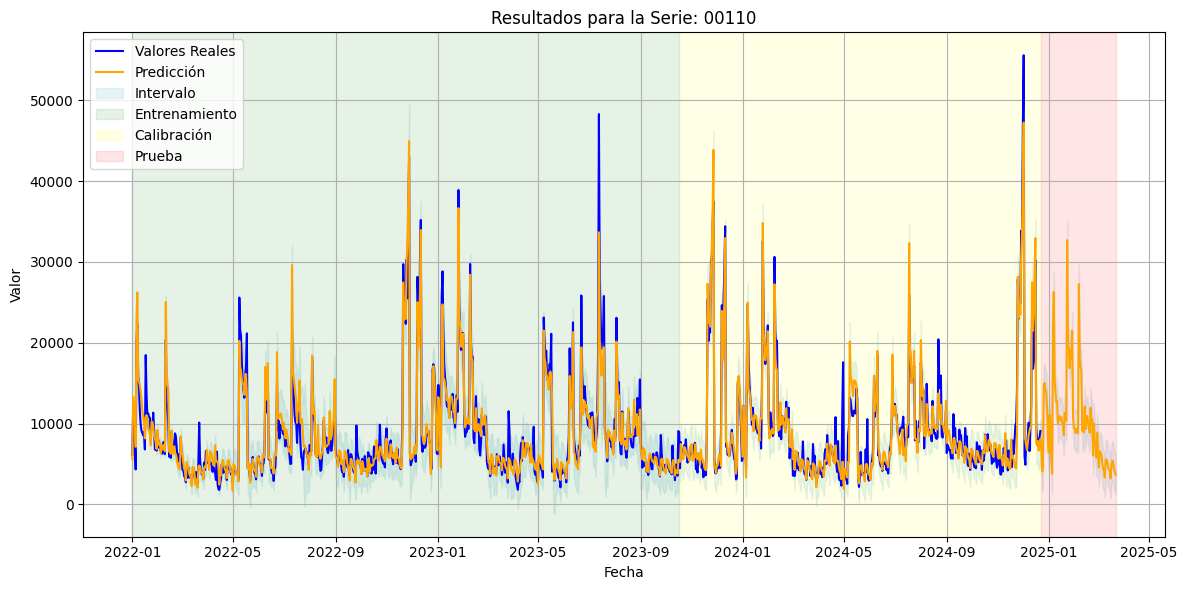

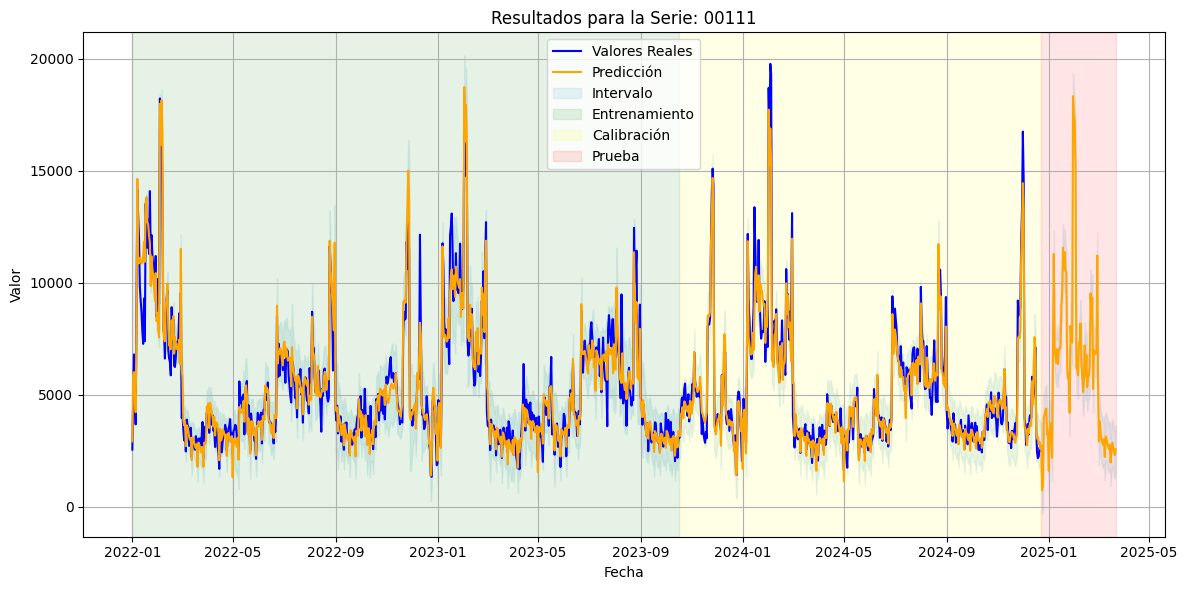

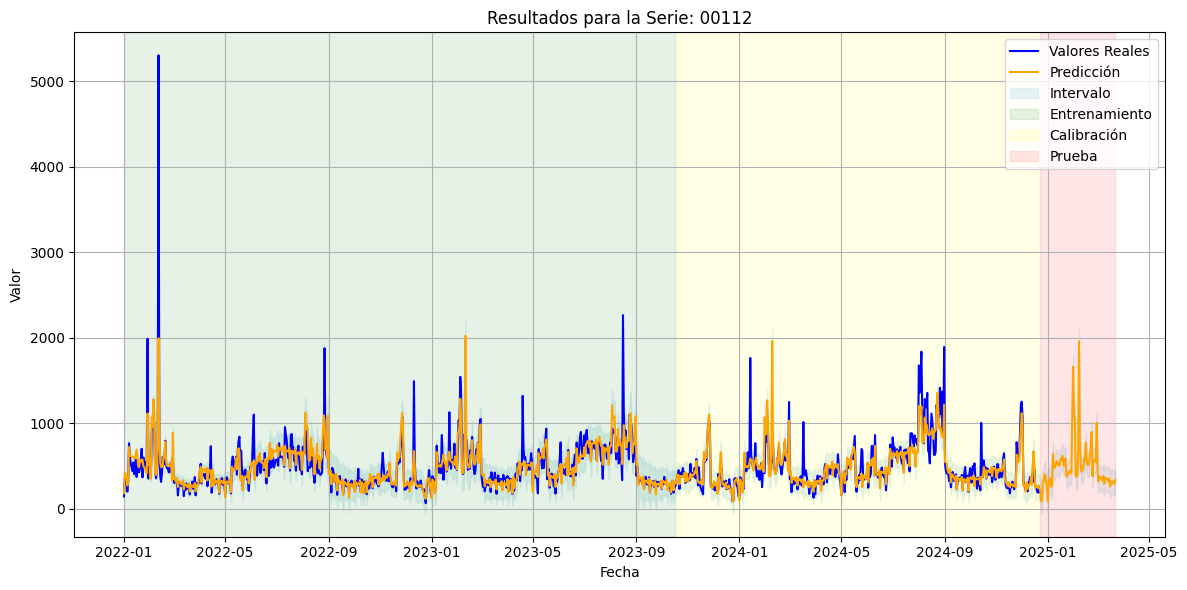

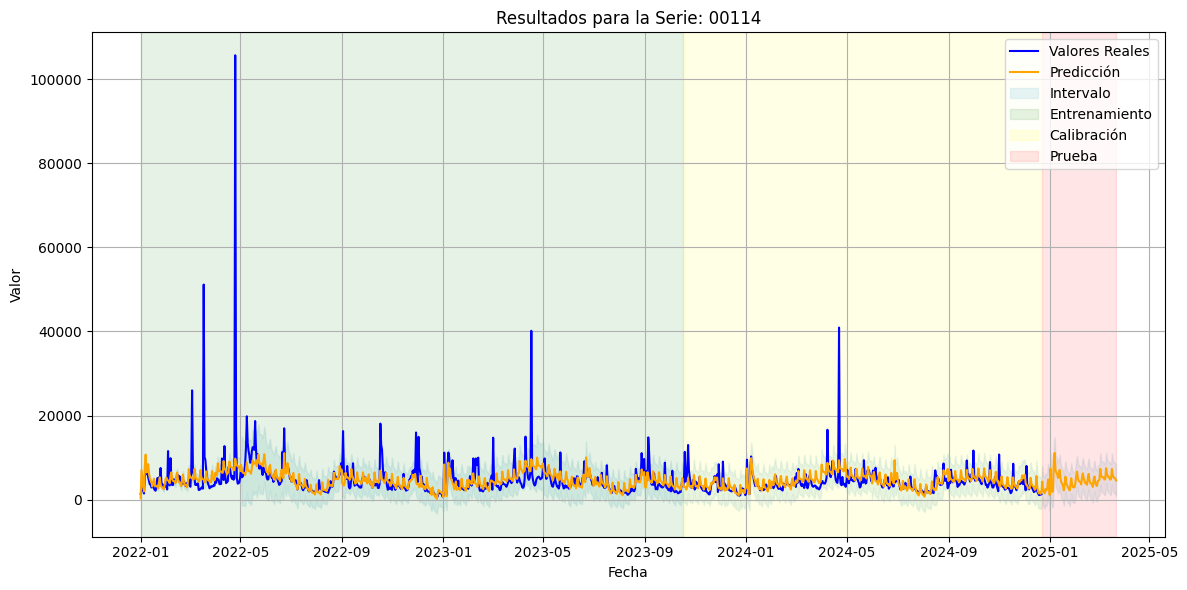

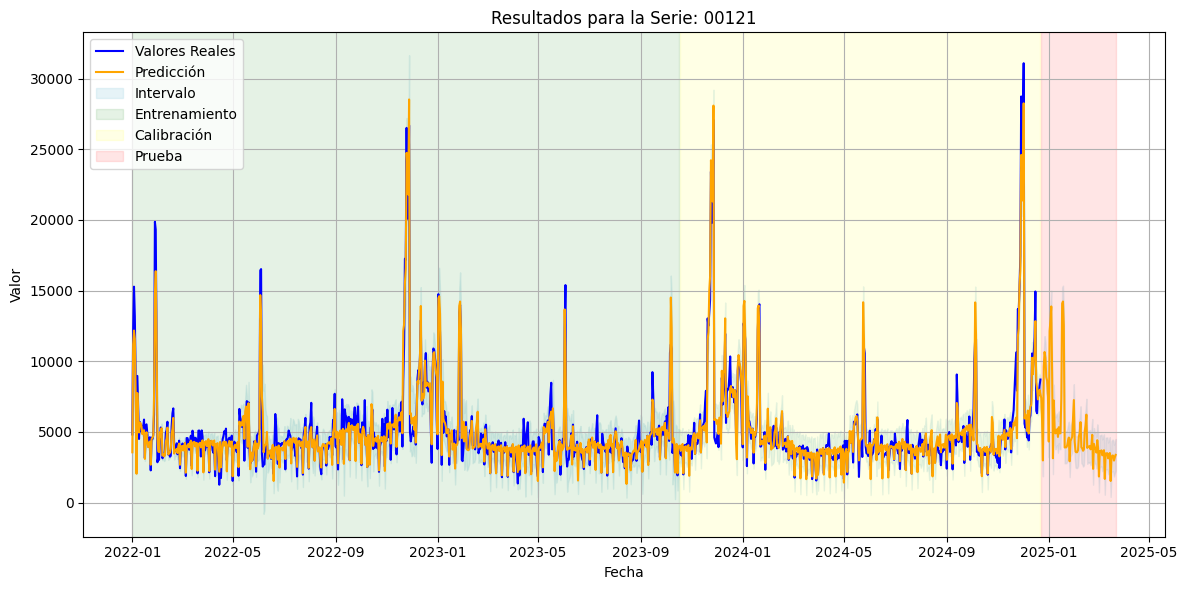

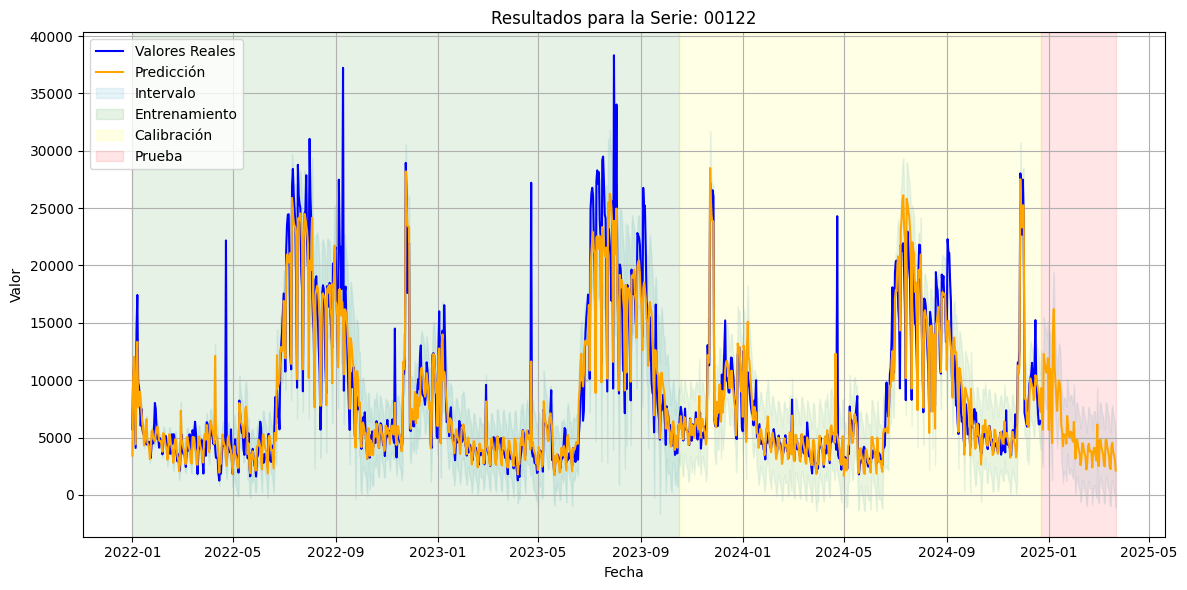

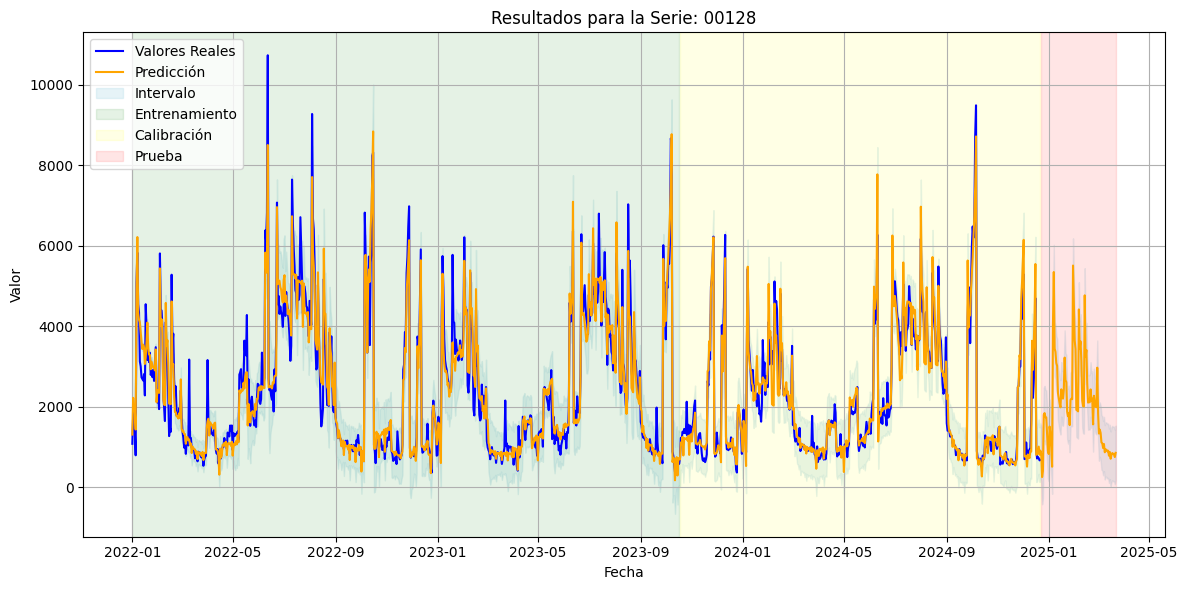

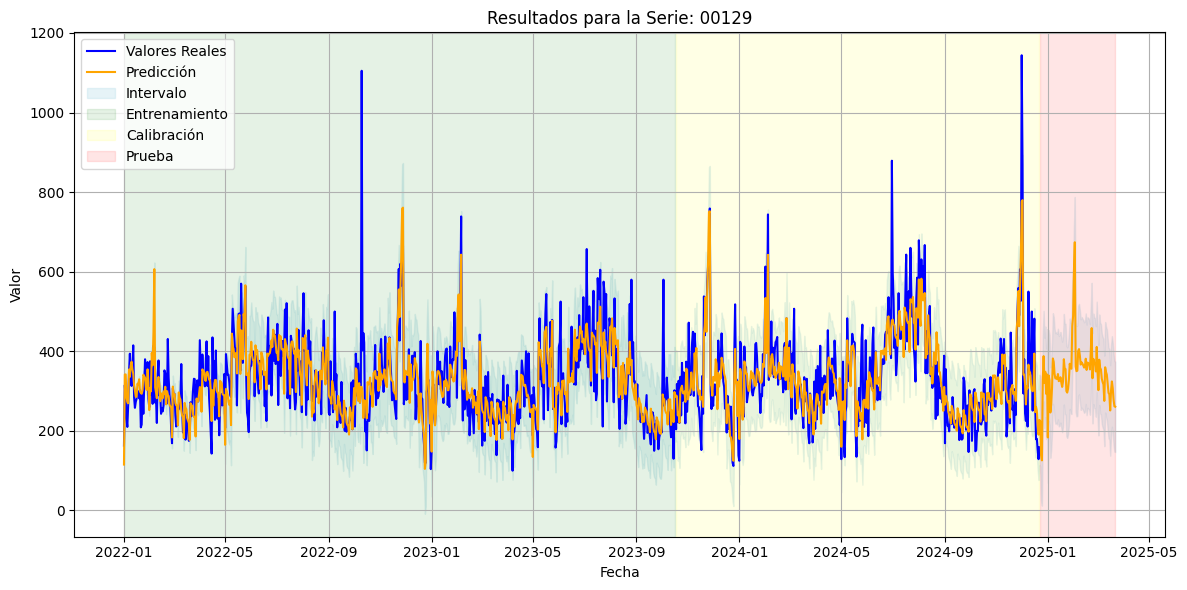

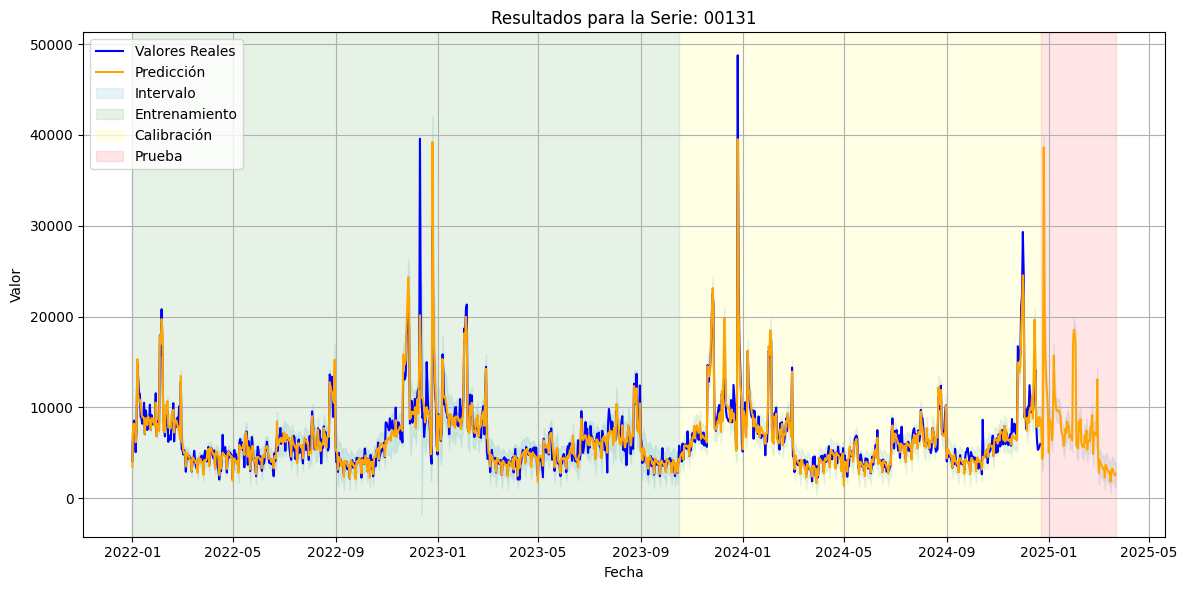

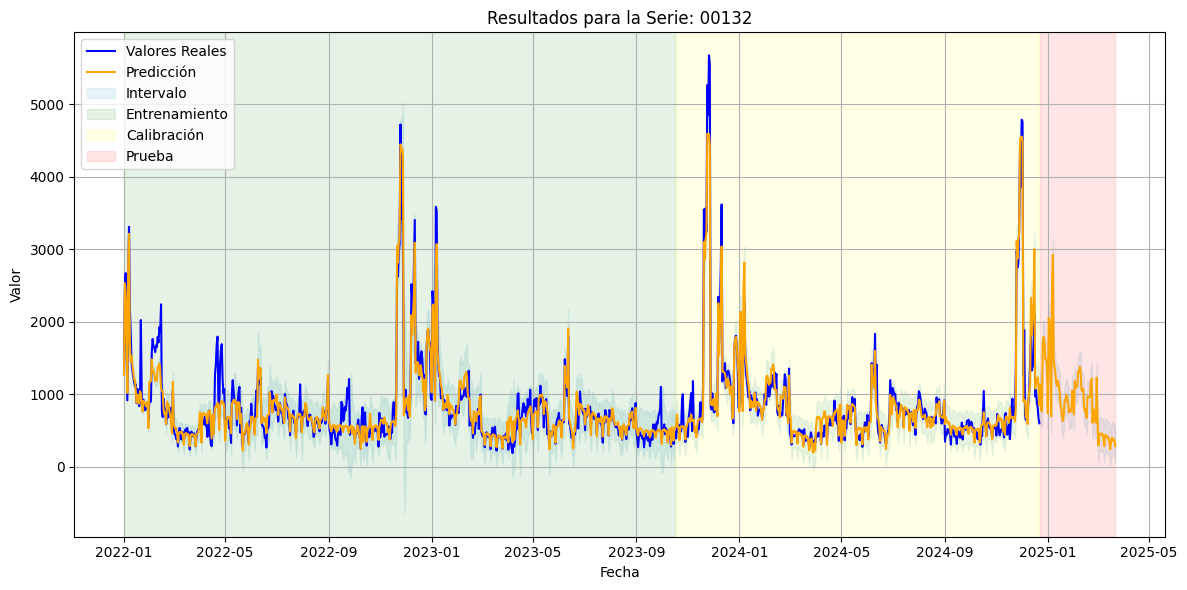

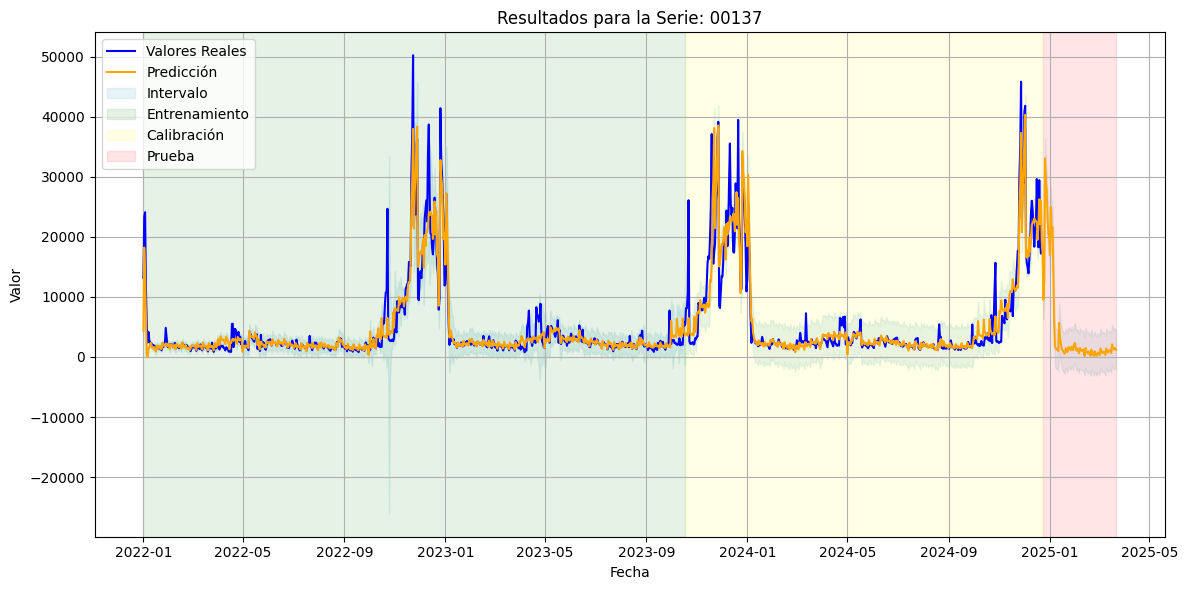

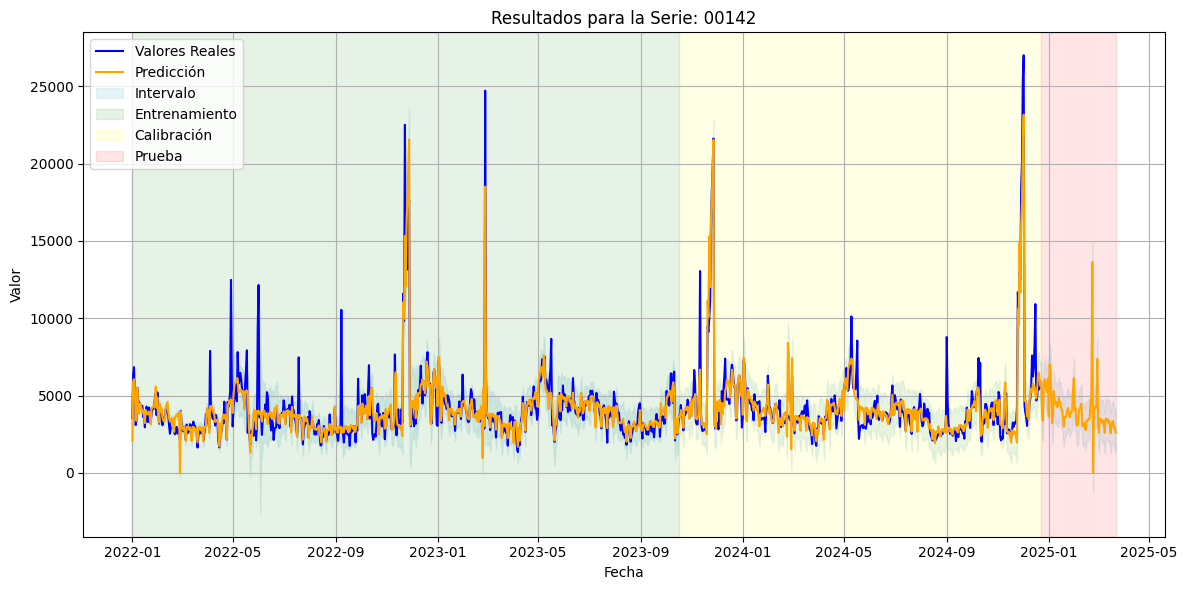

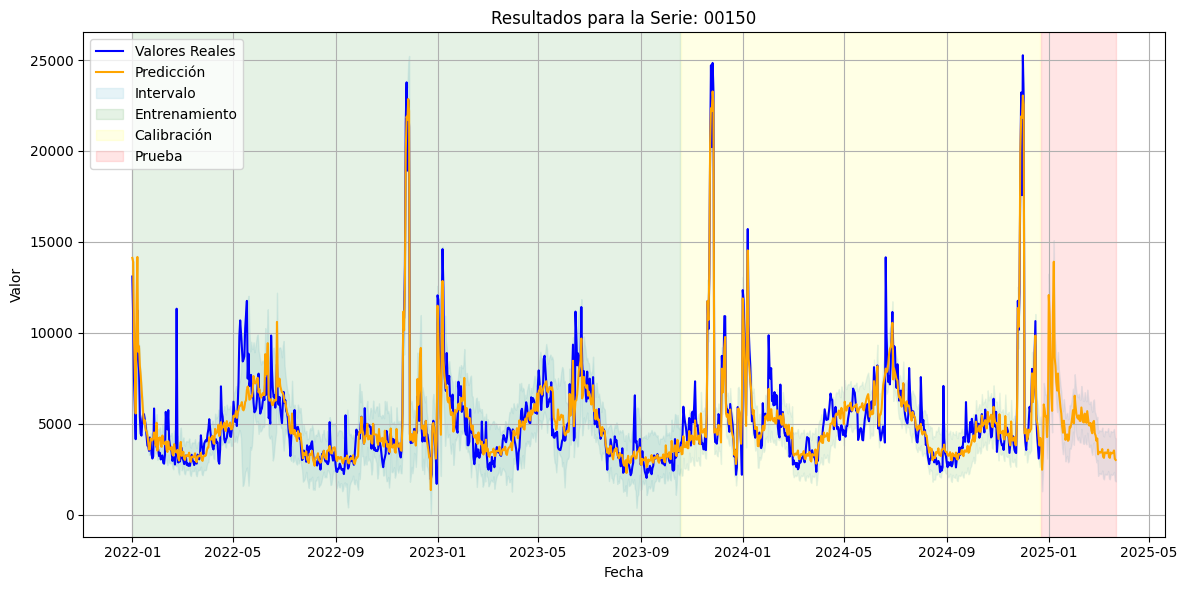

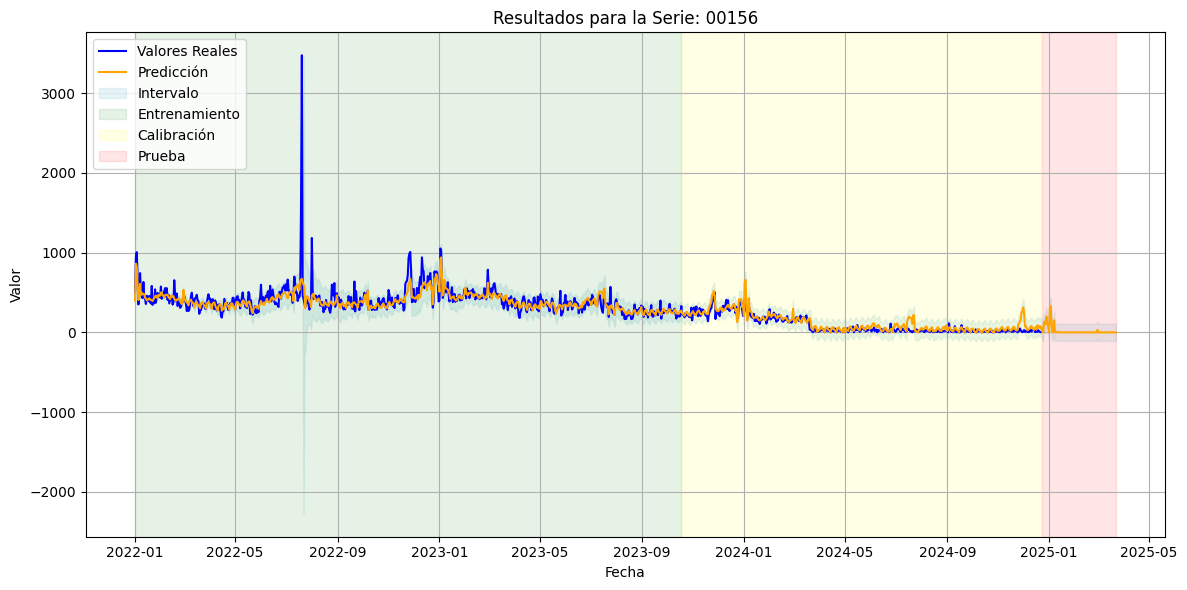

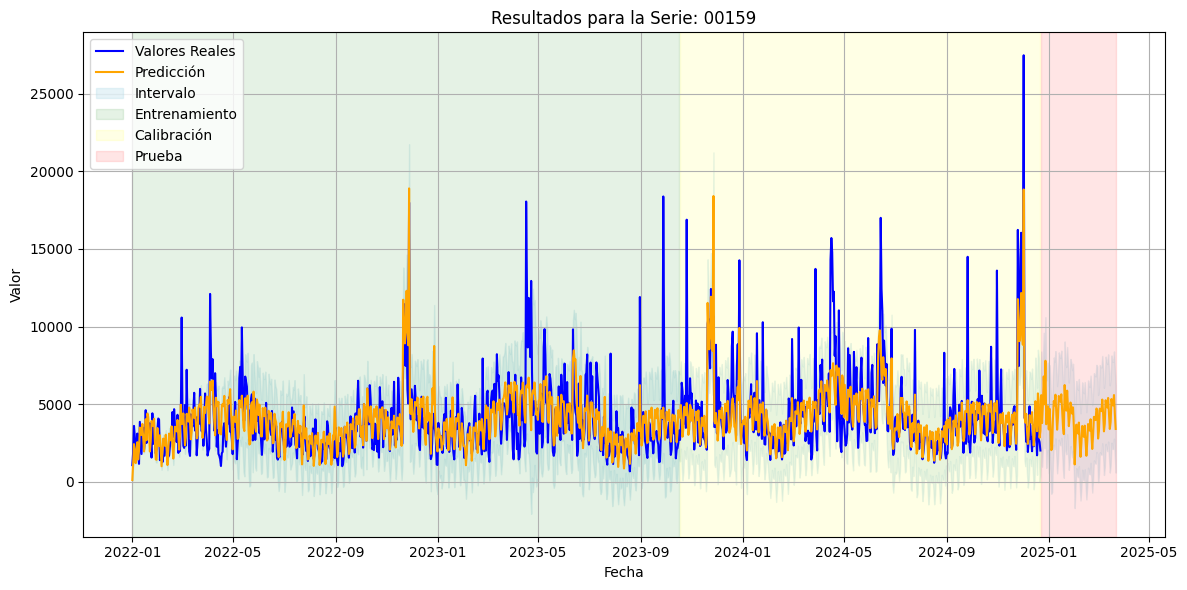

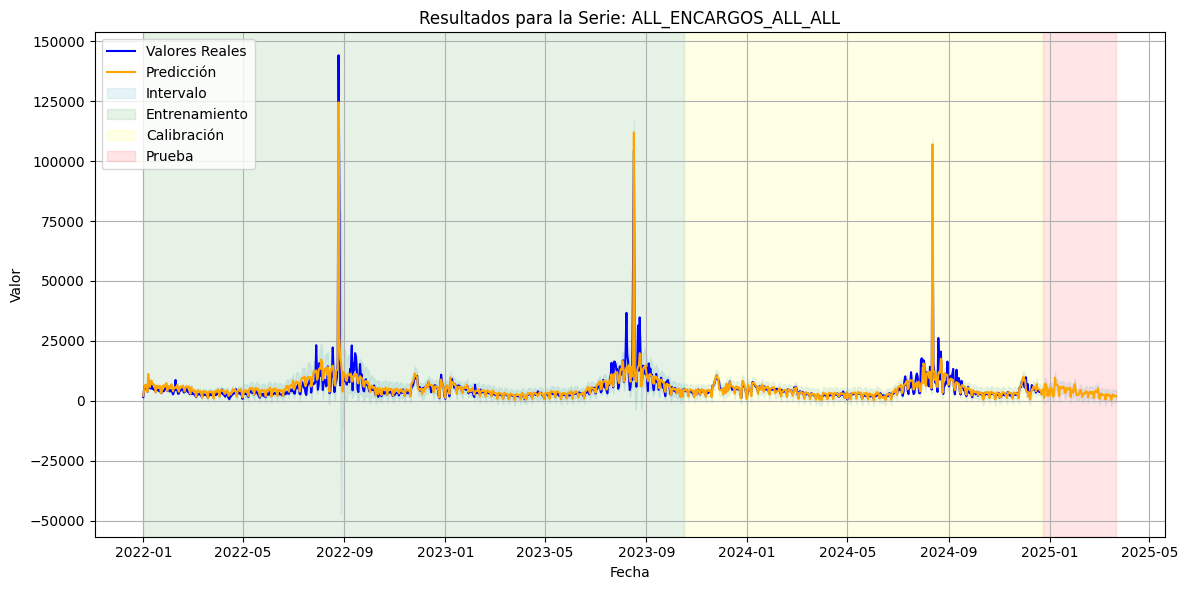

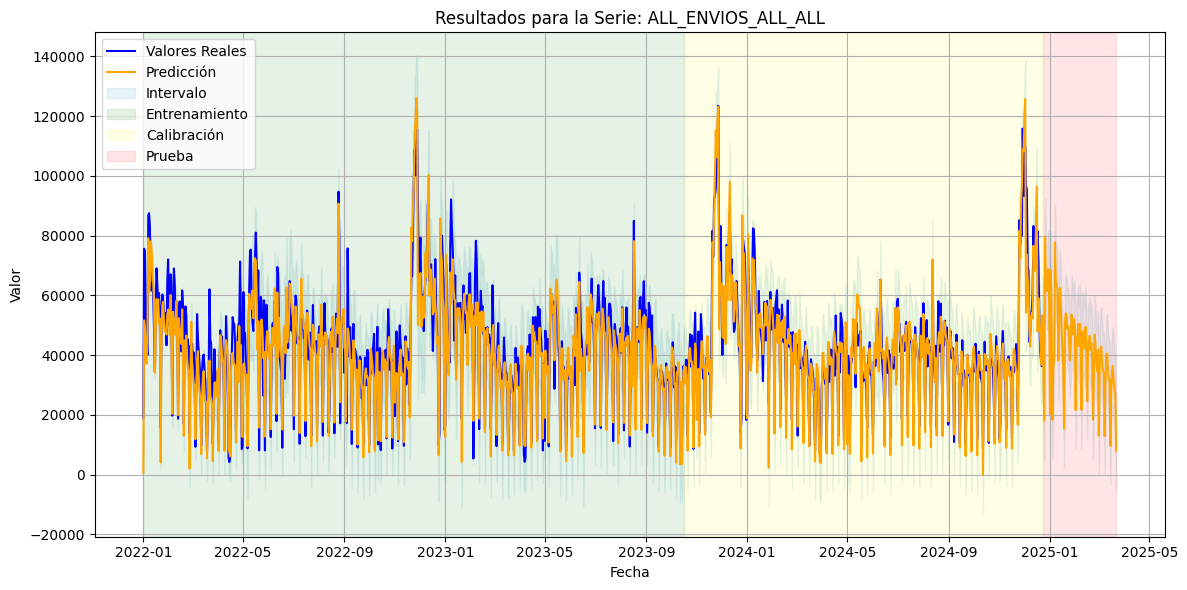

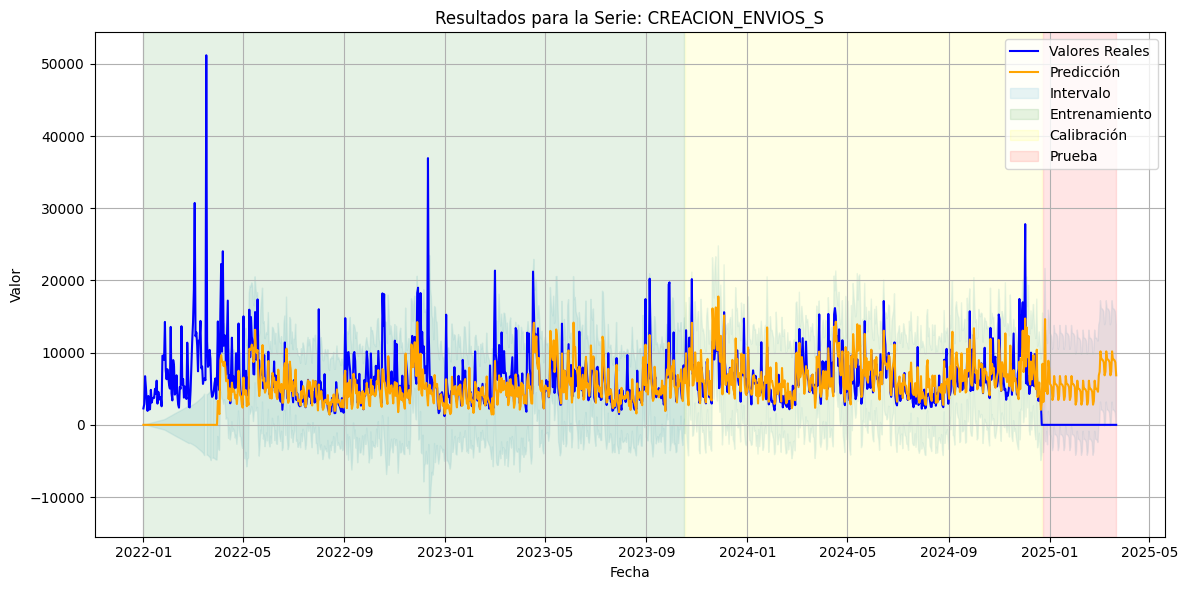

In [13]:
# Bucle para visualizar resultados para todas las series
unique_keys = df_pdi['KEY'].unique()

for key in unique_keys:
    plot_series_results_with_sets(df_pdi, key=key)

In [14]:
# Dividir el DataFrame en TRAIN, CALIBRATION y TEST
train_df = df_pdi[df_pdi["SET"] == "TRAIN"]
calib_df = df_pdi[df_pdi["SET"] == "CALIBRATION"]
test_df = df_pdi[df_pdi["SET"] == "TEST"]

# Calcular métricas por serie (KEY) para el conjunto de calibración
calib_metrics_by_key = calculate_metrics(
    calib_df,
    value_col="Y",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha,
    condition_col="KEY"
)

# Mostrar resultados
print("Métricas por KEY (Calibración):")
print(calib_metrics_by_key.to_string())


Métricas por KEY (Calibración):
                   Group  Marginal Coverage  Coverage Deviation  Average Region Size  Winkler Score
0                  00101           0.893271           -0.056729          1036.345351    3671.916574
1                  00102           0.879630           -0.070370           891.763751    3082.116011
2                  00104           0.837963           -0.112037          2042.783099    6454.507143
3                  00105           0.923611           -0.026389          2638.817479    4870.861593
4                  00106           0.912037           -0.037963          1687.828042    3602.642612
5                  00107           0.884259           -0.065741          4589.009074   12143.274058
6                  00108           0.951389            0.001389          3161.272230    4818.140378
7                  00109           0.884259           -0.065741          2458.433144    6125.580258
8                  00110           0.870370           -0.079630     